In [1]:
import os
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Move working directory to project root
os.chdir(Path.cwd().parents[0])
print("CWD:", Path.cwd())

CWD: /home/tchen/casual-pricing-lab


In [3]:
pd.options.display.float_format = "{:,.3f}".format
sns.set(rc={"figure.figsize": (8, 4)})

paths = yaml.safe_load(open("configs/paths.yaml"))
FIGDIR = Path("reports/figures"); FIGDIR.mkdir(parents=True, exist_ok=True)

df_tx = pd.read_parquet(paths["interim_clean"])
df_daily = pd.read_parquet(paths["processed_daily"])

df_tx.shape, df_daily.shape, df_tx.head(2), df_daily.head(2)

((27366, 28),
 (7849, 6),
   Order ID                   Product  Quantity Ordered  Price Each  \
 0   177831  Lightning Charging Cable                 1      14.950   
 1   177687          Wired Headphones                 1      11.990   
 
            Order Date                       Purchase Address  Revenue  year  \
 0 2019-04-01 03:09:00    914 6th St, San Francisco, CA 94016   14.950  2019   
 1 2019-04-01 04:12:00  23 Meadow St, San Francisco, CA 94016   11.990  2019   
 
    month  day  ...      city_norm  city_Atlanta city_Austin city_Boston  \
 0      4    1  ...  San Francisco             0           0           0   
 1      4    1  ...  San Francisco             0           0           0   
 
   city_Dallas  city_Los Angeles city_New York City  city_Portland  \
 0           0                 0                  0              0   
 1           0                 0                  0              0   
 
   city_San Francisco  city_Seattle  
 0                  1             0  

In [4]:
# Basic structure and missingness
summary = {
    "tx_rows": len(df_tx),
    "daily_rows": len(df_daily),
    "n_products": df_tx["Product"].nunique(),
    "n_cities": df_tx["city"].nunique(),
    "date_min": df_tx["Order Date"].min(),
    "date_max": df_tx["Order Date"].max(),
}
miss_tx = df_tx.isna().mean().sort_values(ascending=False).head(10)
miss_daily = df_daily.isna().mean().sort_values(ascending=False).head(10)

summary, miss_tx, miss_daily

({'tx_rows': 27366,
  'daily_rows': 7849,
  'n_products': 19,
  'n_cities': 9,
  'date_min': Timestamp('2019-04-01 03:09:00'),
  'date_max': Timestamp('2019-09-01 04:45:00')},
 Order ID           0.000
 Product            0.000
 Quantity Ordered   0.000
 Price Each         0.000
 Order Date         0.000
 Purchase Address   0.000
 Revenue            0.000
 year               0.000
 month              0.000
 day                0.000
 dtype: float64,
 date        0.000
 product     0.000
 city        0.000
 qty         0.000
 revenue     0.000
 avg_price   0.000
 dtype: float64)

(                       Product       Revenue
 13          Macbook Pro Laptop 1,273,300.000
 18                      iPhone   790,300.000
 14             ThinkPad Laptop   666,993.330
 9                 Google Phone   562,200.000
 3       34in Ultrawide Monitor   389,489.750
 1       27in 4K Gaming Monitor   388,040.050
 6     Apple Airpods Headphones   373,800.000
 8                Flatscreen TV   236,100.000
 7   Bose SoundSport Headphones   213,078.690
 2             27in FHD Monitor   181,487.900,
             city       Revenue
 7  San Francisco 1,335,747.940
 4    Los Angeles   885,467.270
 5  New York City   736,870.440
 2         Boston   585,184.800
 8        Seattle   459,539.130
 0        Atlanta   449,162.870
 3         Dallas   428,782.330
 6       Portland   389,461.290
 1         Austin   294,883.200,
    month       Revenue
 0      4 3,340,302.600
 1      5    10,551.610
 2      8 2,212,148.320
 3      9     2,096.740)

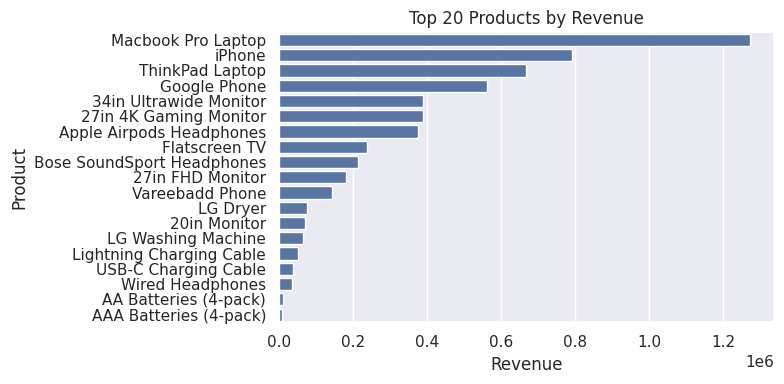

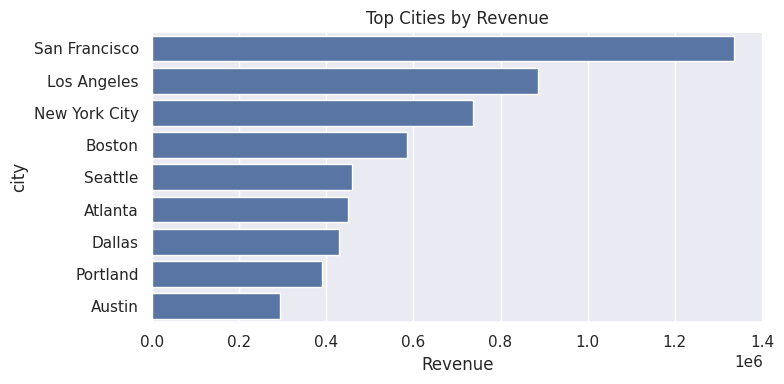

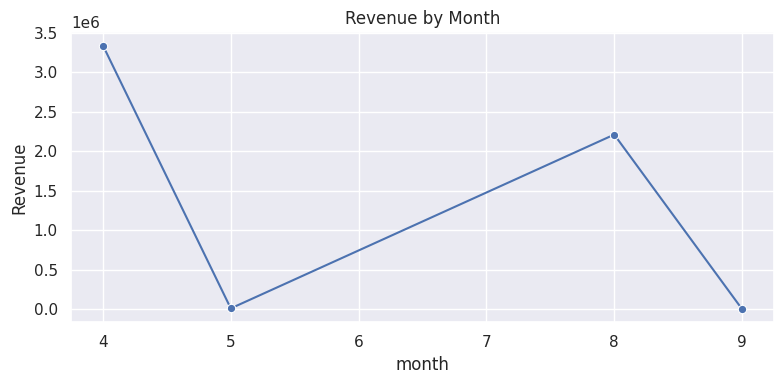

In [5]:
# Top products by revenue
top_products = (
    df_tx.groupby("Product", as_index=False)["Revenue"].sum()
         .sort_values("Revenue", ascending=False)
         .head(20)
)
ax = sns.barplot(data=top_products, y="Product", x="Revenue")
ax.set_title("Top 20 Products by Revenue")
plt.tight_layout(); plt.savefig(FIGDIR / "top_products_revenue.png")

# Top cities by revenue
top_cities = (
    df_tx.groupby("city", as_index=False)["Revenue"].sum()
         .sort_values("Revenue", ascending=False)
         .head(15)
)
plt.figure()
ax = sns.barplot(data=top_cities, y="city", x="Revenue")
ax.set_title("Top Cities by Revenue")
plt.tight_layout(); plt.savefig(FIGDIR / "top_cities_revenue.png")

# Revenue by month
rev_by_month = (
    df_tx.groupby("month", as_index=False)["Revenue"].sum()
         .sort_values("month")
)
plt.figure()
ax = sns.lineplot(data=rev_by_month, x="month", y="Revenue", marker="o")
ax.set_title("Revenue by Month")
plt.tight_layout(); plt.savefig(FIGDIR / "revenue_by_month.png")

top_products.head(10), top_cities.head(10), rev_by_month


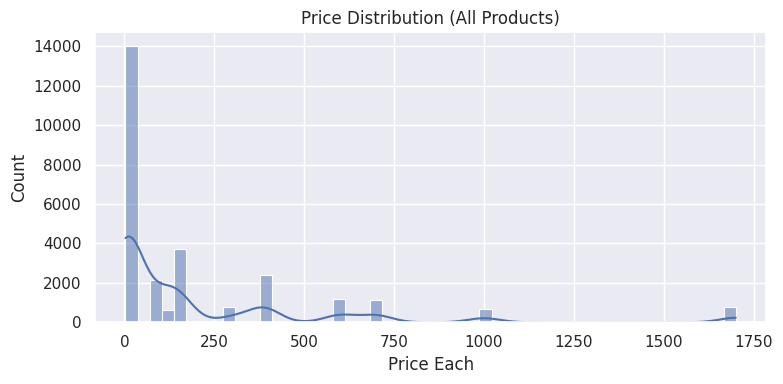

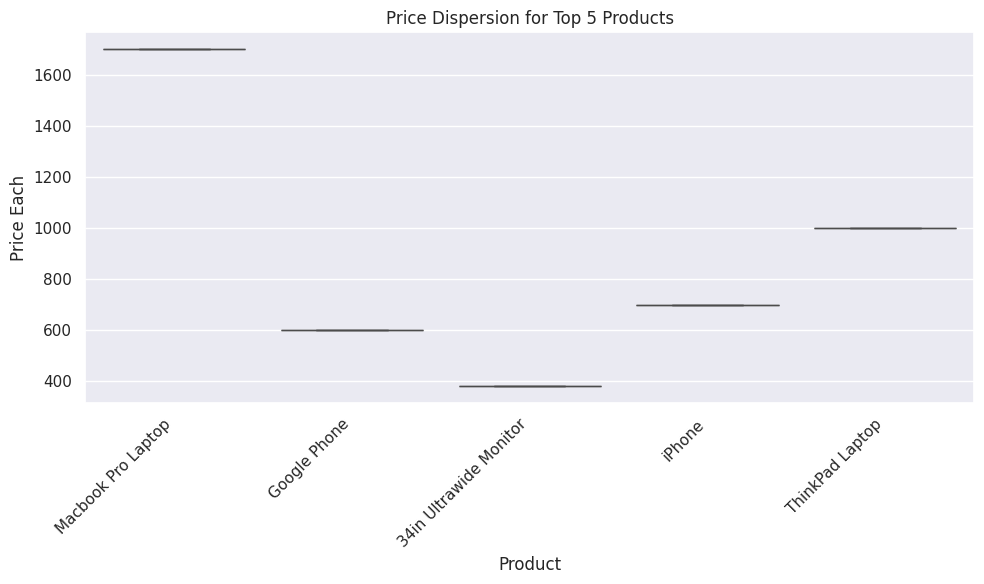

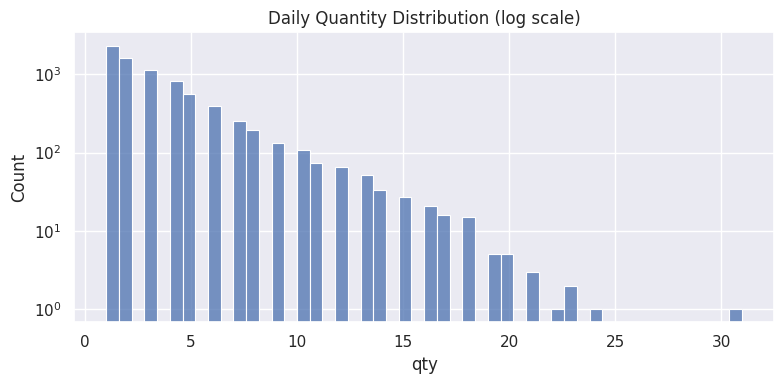

In [6]:
# Distribution of prices overall and for a few popular products
plt.figure()
sns.histplot(df_tx["Price Each"], bins=50, kde=True)
plt.title("Price Distribution (All Products)")
plt.tight_layout(); plt.savefig(FIGDIR / "price_distribution_all.png")

popular = top_products["Product"].head(5).tolist()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_tx[df_tx["Product"].isin(popular)], x="Product", y="Price Each")
plt.xticks(rotation=45, ha="right")
plt.title("Price Dispersion for Top 5 Products")
plt.tight_layout(); plt.savefig(FIGDIR / "price_box_top5.png")

# Quantity distribution at daily grain (avoids duplicates per order)
plt.figure()
sns.histplot(df_daily["qty"], bins=50, kde=False)
plt.yscale("log")
plt.title("Daily Quantity Distribution (log scale)")
plt.tight_layout(); plt.savefig(FIGDIR / "qty_distribution_daily.png")


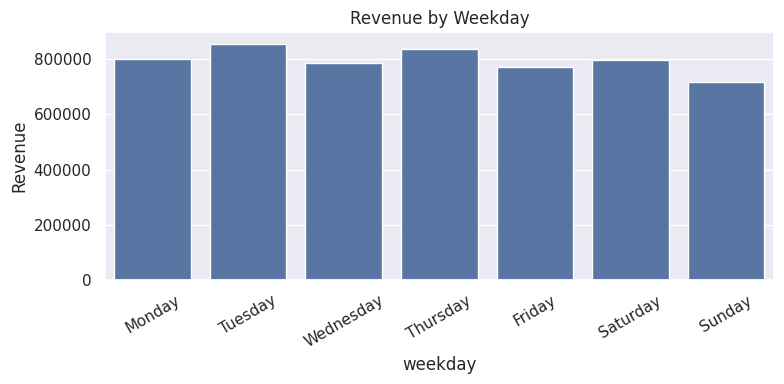

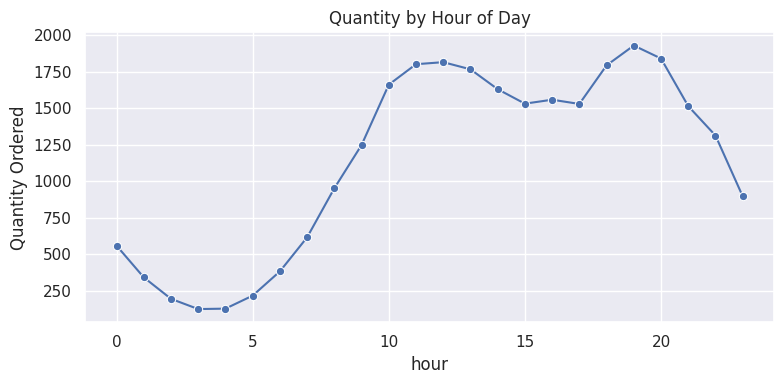

In [7]:
# Weekday revenue pattern
rev_by_wd = (
    df_tx.groupby("weekday", as_index=False)["Revenue"].sum()
         .assign(weekday_num=lambda d: pd.Categorical(d["weekday"],
                                                      categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                                                      ordered=True).codes)
         .sort_values("weekday_num")
)
plt.figure()
sns.barplot(data=rev_by_wd, x="weekday", y="Revenue")
plt.xticks(rotation=30)
plt.title("Revenue by Weekday")
plt.tight_layout(); plt.savefig(FIGDIR / "revenue_by_weekday.png")

# Hour-of-day quantity pattern
qty_by_hour = df_tx.groupby("hour", as_index=False)["Quantity Ordered"].sum()
plt.figure()
sns.lineplot(data=qty_by_hour, x="hour", y="Quantity Ordered", marker="o")
plt.title("Quantity by Hour of Day")
plt.tight_layout(); plt.savefig(FIGDIR / "qty_by_hour.png")


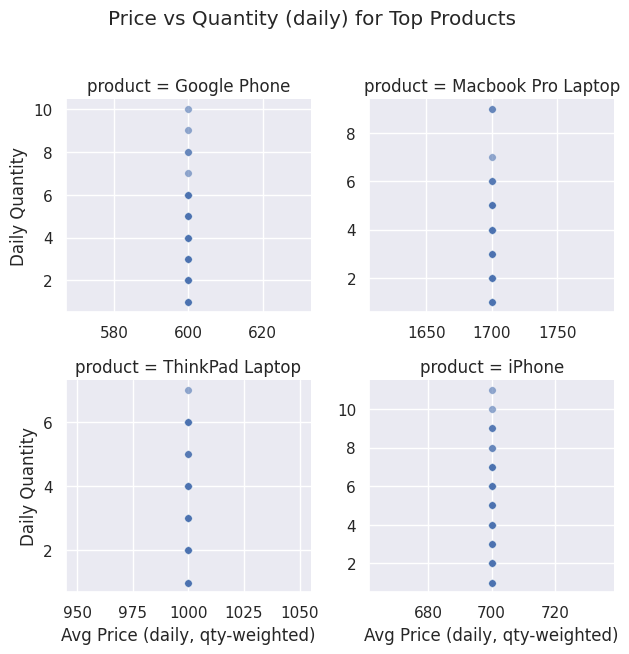

In [8]:
# Select a few top products and inspect daily price-quantity scatter
focus = top_products["Product"].head(4).tolist()
g = sns.FacetGrid(df_daily[df_daily["product"].isin(focus)], col="product", col_wrap=2, sharex=False, sharey=False, height=3.2)
g.map_dataframe(sns.scatterplot, x="avg_price", y="qty", alpha=0.6, s=30)
g.set_axis_labels("Avg Price (daily, qty-weighted)", "Daily Quantity")
g.fig.suptitle("Price vs Quantity (daily) for Top Products", y=1.02)
plt.tight_layout(); plt.savefig(FIGDIR / "scatter_price_qty_top.png")


,date,product,city,qty,revenue,avg_price,qty_roll,price_roll
92,2019-04-01,Macbook Pro Laptop,Atlanta,1,"1,700.000","1,700.000",NaN,NaN
93,2019-04-01,Macbook Pro Laptop,Austin,1,"1,700.000","1,700.000",NaN,NaN
94,2019-04-01,Macbook Pro Laptop,Boston,3,"5,100.000","1,700.000",1.667,"1,700.000"
95,2019-04-01,Macbook Pro Laptop,Dallas,1,"1,700.000","1,700.000",1.500,"1,700.000"
96,2019-04-01,Macbook Pro Laptop,Los Angeles,4,"6,800.000","1,700.000",2.000,"1,700.000"


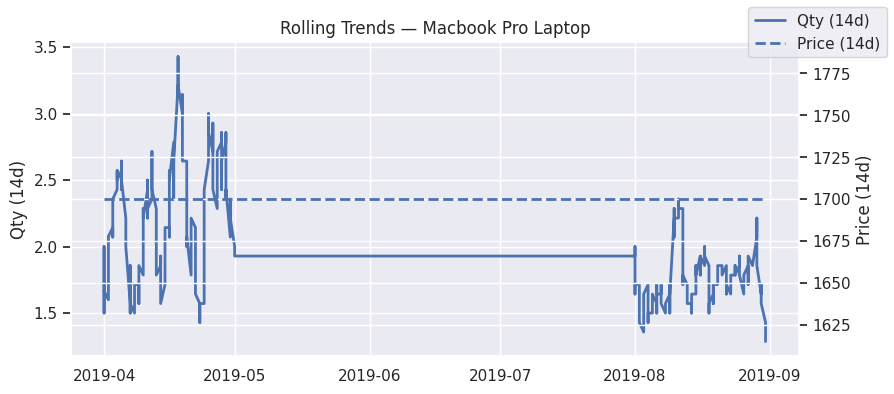

In [9]:
# Rolling 14-day trends for a single popular product
p = popular[0]
tmp = (df_daily[df_daily["product"] == p]
       .sort_values("date")
       .assign(qty_roll=lambda d: d["qty"].rolling(14, min_periods=3).mean(),
               price_roll=lambda d: d["avg_price"].rolling(14, min_periods=3).mean())
)
fig, ax1 = plt.subplots(figsize=(9, 4))
ax1.plot(tmp["date"], tmp["qty_roll"], label="Qty (14d)", linewidth=2)
ax1.set_ylabel("Qty (14d)")
ax2 = ax1.twinx()
ax2.plot(tmp["date"], tmp["price_roll"], label="Price (14d)", linewidth=2, linestyle="--")
ax2.set_ylabel("Price (14d)")
ax1.set_title(f"Rolling Trends — {p}")
fig.legend(loc="upper right")
plt.tight_layout(); plt.savefig(FIGDIR / f"rolling_price_qty_{p.replace(' ','_')}.png")
tmp.head()


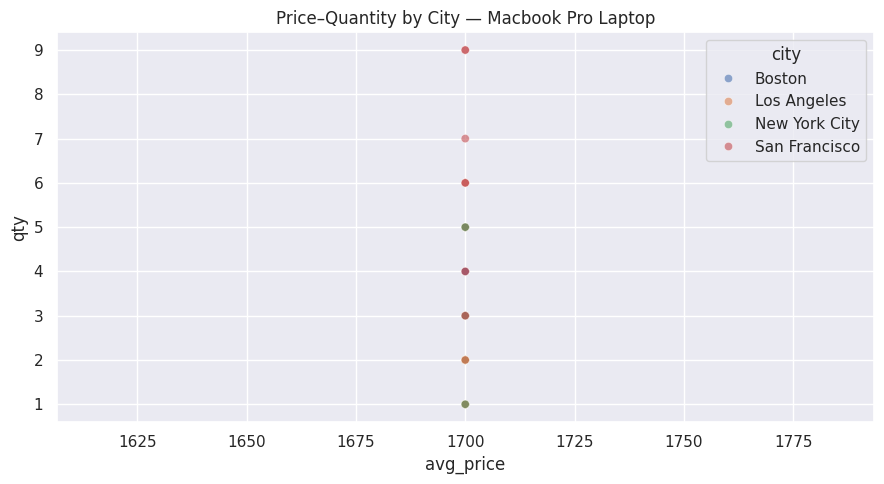

In [10]:
# Compare two cities for the same product
p = popular[0]
cities = top_cities["city"].head(4).dropna().tolist()
seg = df_daily[(df_daily["product"] == p) & (df_daily["city"].isin(cities))]
plt.figure(figsize=(9, 5))
sns.scatterplot(data=seg, x="avg_price", y="qty", hue="city", alpha=0.6)
plt.title(f"Price–Quantity by City — {p}")
plt.tight_layout(); plt.savefig(FIGDIR / f"scatter_city_{p.replace(' ','_')}.png")


In [11]:
# Correlation between daily avg_price and qty (per product), signal only
corrs = (df_daily.groupby("product")
         .apply(lambda d: np.corrcoef(d["avg_price"], d["qty"])[0,1] if len(d) >= 10 else np.nan)
         .rename("corr_price_qty")
         .reset_index()
         .dropna()
         .sort_values("corr_price_qty"))
corrs.head(15), corrs.tail(15)


/home/tchen/casual-pricing-lab/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tchen/casual-pricing-lab/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_106086/1357629422.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.corrcoef(d["avg_price"], d["qty"])[0,1] if len(d) >= 10 else np.nan)


(                       product  corr_price_qty
 5       AAA Batteries (4-pack)          -0.058
 0                 20in Monitor          -0.026
 7   Bose SoundSport Headphones           0.000
 4        AA Batteries (4-pack)           0.010
 3       34in Ultrawide Monitor           0.016
 1       27in 4K Gaming Monitor           0.022
 12    Lightning Charging Cable           0.029
 15        USB-C Charging Cable           0.079
 17            Wired Headphones           0.313
 14             ThinkPad Laptop           0.490,
                        product  corr_price_qty
 5       AAA Batteries (4-pack)          -0.058
 0                 20in Monitor          -0.026
 7   Bose SoundSport Headphones           0.000
 4        AA Batteries (4-pack)           0.010
 3       34in Ultrawide Monitor           0.016
 1       27in 4K Gaming Monitor           0.022
 12    Lightning Charging Cable           0.029
 15        USB-C Charging Cable           0.079
 17            Wired Headphones        

In [12]:
OUTDIR = Path("reports"); OUTDIR.mkdir(exist_ok=True, parents=True)
top_products.to_csv(OUTDIR / "top_products_revenue.csv", index=False)
top_cities.to_csv(OUTDIR / "top_cities_revenue.csv", index=False)
corrs.to_csv(OUTDIR / "corr_price_qty_by_product.csv", index=False)
rev_by_month.to_csv(OUTDIR / "revenue_by_month.csv", index=False)
"saved"


'saved'

### 📊 Exploratory Data Analysis — Key Insights
#### 1. Price structure

- The overall price distribution is heavily right-skewed: most products cluster under $100, but there are distinct peaks at higher brackets (e.g., around $400, $700, $1,000, and $1,700).
- Top 5 products (MacBook Pro, iPhone, Google Phone, ThinkPad Laptop, 34in Ultrawide Monitor) show very stable prices with little dispersion. This suggests they were sold at a fixed list price with minimal discounts.
- Implication: for these products, price elasticity estimates may be unreliable since there’s limited variation in price. Elasticity is best estimated for products with some price fluctuation.

#### 2. Quantity distribution & purchasing behavior

- Daily quantities follow a long-tail: most product-day-city cells sell only a handful of units, but a few reach 20–30 units/day.
- Hourly ordering patterns show two peaks:
- Late morning (10-12h) when people are shopping online at work.
- Evening (19-20h) when consumers are at home.
This double-hump is consistent with e-commerce traffic.

#### 3. Temporal trends
- Monthly revenue is uneven: April and August dominate, while May and September drop sharply (likely incomplete data in those months).
- Weekday patterns: fairly flat across the week, but Tuesday and Thursday are slightly stronger sales days, while Sunday is weaker.

#### 4. Geographic concentration
- Revenue is concentrated in large urban markets: San Francisco, Los Angeles, and New York lead by a wide margin.
- This aligns with expectations of higher purchasing power and e-commerce penetration in major U.S. cities.

#### 5. Price–quantity relationships (early elasticity signals)
Scatter plots of price vs. daily quantity show:
- For many high-revenue products (MacBook, iPhone, ThinkPad), prices are almost flat → elasticity hard to identify.
- For lower- to mid-price items with more variation, some negative correlation between price and quantity appears (confirmed by the correlation table).
- Example: correlation file (corr_price_qty_by_product.csv) shows that for some accessories, higher prices are associated with lower daily quantities, a classic signal of elasticity.

#### 6. Rolling trends (MacBook Pro example)

Quantity fluctuates but price is nearly constant → no natural variation to learn elasticity.

This confirms that elasticity modeling should focus on products/categories where price actually moves.



### 🔑 Takeaways for Next Steps

#### 1. Elasticity estimation should start with products that:

- Have meaningful price variation.
- Appear in multiple cities (enables richer controls).
- Have ≥30 observations (for stable regression).
- We may downweight or exclude flagship items with fixed prices (MacBook, iPhone).

#### 2. Controls for DML:

- Time effects (month, weekday, hour).
- City fixed effects (San Francisco, LA, NYC).

### 3. Business framing:

- Products with stable prices ≈ “inelastic” in this dataset.
- Accessories and mid-priced items likely show the strongest elasticity.